In [1]:
from transformers import BertModel,BertTokenizer,FlaubertTokenizer, FlaubertModel,AutoTokenizer, BertForSequenceClassification , FlaubertForSequenceClassification
from transformers.modeling_utils import SequenceSummary
from tensorboardX import SummaryWriter
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.nn.utils.rnn import pack_padded_sequence
import sys
import re
from easy_nlp.models import LstmBertForClassification
from easy_nlp.training import Train
from easy_nlp.preprocessing import TextPreprocessing
from easy_nlp.feature_extraction import MetaFeaturesExtraction
from easy_nlp.data_visualisation import WordCloudMaker
from transformers import  AutoModel
 

/home/aboumada/anaconda3/envs/torch_tf/lib/python3.7/site-packages/treetaggerwrapper.py:740: FutureWarning: Possible nested set at position 8
  re.IGNORECASE | re.VERBOSE)
/home/aboumada/anaconda3/envs/torch_tf/lib/python3.7/site-packages/treetaggerwrapper.py:2044: FutureWarning: Possible nested set at position 152
  re.VERBOSE | re.IGNORECASE)
/home/aboumada/anaconda3/envs/torch_tf/lib/python3.7/site-packages/treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
/home/aboumada/anaconda3/envs/torch_tf/lib/python3.7/site-packages/treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)


In [2]:
writer = SummaryWriter('runs/test')

In [3]:
import pandas as pd
df = pd.read_csv("/data/aboumada/Data/3_Datasets/full_df_noFeatures_Preapred.csv")
#df=df[df.classe2 != 'Poubelle']
len(df)

12826

In [4]:
text_preprocessing = TextPreprocessing(df,"TEXT")
text_preprocessing.fit_transform()

In [5]:
#df['processed_text']=df['processed_text'].str.replace(r'pic.twitter.com(.*?)\s(.*)', '')

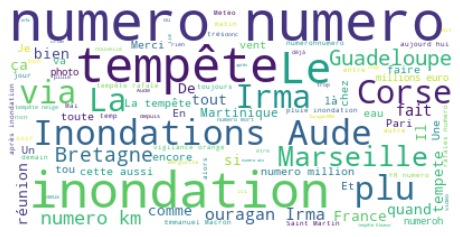

In [6]:
cloudMaker = WordCloudMaker.fit(df['processed_text'])

## Run if Random Sampling 

In [7]:
from sklearn.model_selection import train_test_split
df_train , df_test = train_test_split(df,random_state=1, test_size=0.2)


## Run if Out of event 

In [8]:
#events_test= ['Bruno', 'Eleanor']
#df_test = df[df.event.isin(events_test)]
#df_train = df[~df.event.isin(events_test)]

## Run if Out of Type 

In [9]:
#events_test= ['EffondrementMarseille']
#df_train=df_en[['text_clean','CAT']]

In [10]:
def get_sentences_labels(df,text_column='text_clean',label_column='CAT',cat_labels=None):
    dic_cat_labels = cat_labels if cat_labels is not None else {x:value for x,value in enumerate(df[label_column].unique())}
    dic_labels_to_cat = {value:x for x,value in dic_cat_labels.items() }
    #df[text_column]= df[text_column].map(lambda text_clean : re.sub('["#$%&()*+,-./:;<=>@[\]^_`{|}~\n\t’\']', '', text_clean))
    df2 = df[label_column].map(dic_labels_to_cat)
    sentences = df[text_column].values
    labels = df2.values.astype(int)
    return sentences,labels,dic_cat_labels

sentences_train,labels_train,dic_cat_labels=get_sentences_labels(df_train,text_column='processed_text',label_column='CAT')
sentences_test,labels_test,dic_cat_labels=get_sentences_labels(df_test,text_column='processed_text',label_column='CAT',cat_labels=dic_cat_labels)

print(dic_cat_labels)


{0: 'Avertissement-conseil', 1: 'Degats-Materiels', 2: 'AutresMessages', 3: 'Degats-Humains', 4: 'Message-NonUtilisable', 5: 'Soutiens', 6: 'Critiques'}


## Run if you need to remove words used for data scrapping  

In [11]:
'''crisis_names = ['irma','bruno','aude','harvey','eleanor','corse-fione','beryl−guadeloupe','corse','egon','susanna','ulrika','reunion−berguitta','marseille','effondrementmarseille','guadeloupe','corse','immeuble','martinique','saint martin','berguitta']
crisis_scrap = ['marseille','bruno','crue', 'crues', 'aude', 'carcassonne', 'trèbes', 'trebes','corse', 'corsica', 'hautecorse', 'haute-corse','crue','béryl', 'beryl', 'guadeloupe', 'ondetropicale','réunion', 'reunion', 'lareunion', 'fakir', 'laréunion','réunion', 'reunion', 'lareunion',' berguitta',' laréunion','corse', 'fionn', 'corsica', 'ana','irma','ouraganIRMA', 'saintmartin', 'stmartin', 'saintbarthelemy', 'saintbarth', 'stbarth','harvey', 'martinique', 'guadeloupe','egon','ulrika', 'vendée','bretagne','susanna']
crisis_scrap=crisis_scrap+crisis_names
print(crisis_scrap)
for i in range(len(sentences_train)):
    big_regex = re.compile('|'.join(map(re.escape, crisis_scrap)))
    sentences_train[i] = big_regex.sub(" ", sentences_train[i])'''

'crisis_names = [\'irma\',\'bruno\',\'aude\',\'harvey\',\'eleanor\',\'corse-fione\',\'beryl−guadeloupe\',\'corse\',\'egon\',\'susanna\',\'ulrika\',\'reunion−berguitta\',\'marseille\',\'effondrementmarseille\',\'guadeloupe\',\'corse\',\'immeuble\',\'martinique\',\'saint martin\',\'berguitta\']\ncrisis_scrap = [\'marseille\',\'bruno\',\'crue\', \'crues\', \'aude\', \'carcassonne\', \'trèbes\', \'trebes\',\'corse\', \'corsica\', \'hautecorse\', \'haute-corse\',\'crue\',\'béryl\', \'beryl\', \'guadeloupe\', \'ondetropicale\',\'réunion\', \'reunion\', \'lareunion\', \'fakir\', \'laréunion\',\'réunion\', \'reunion\', \'lareunion\',\' berguitta\',\' laréunion\',\'corse\', \'fionn\', \'corsica\', \'ana\',\'irma\',\'ouraganIRMA\', \'saintmartin\', \'stmartin\', \'saintbarthelemy\', \'saintbarth\', \'stbarth\',\'harvey\', \'martinique\', \'guadeloupe\',\'egon\',\'ulrika\', \'vendée\',\'bretagne\',\'susanna\']\ncrisis_scrap=crisis_scrap+crisis_names\nprint(crisis_scrap)\nfor i in range(len(senten

In [12]:
from sklearn.model_selection import train_test_split
from easy_nlp.feature_extraction import BertInput

bert_input= BertInput(AutoTokenizer.from_pretrained('flaubert/flaubert_base_cased'))


X_train = bert_input.fit_transform(sentences_train)
X_test = bert_input.fit_transform(sentences_test)


In [13]:
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels,train_masks,validation_masks = train_test_split(X_train[0], labels_train,X_train[1],random_state=1, test_size=0.2)
# Do the same for the masks.
#train_masks, validation_masks= train_test_split(,random_state=1, test_size=0.2)

test_inputs = X_test[0]
test_masks = X_test[1]
test_labels = labels_test

In [14]:
import torch 
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)


train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)





In [15]:
print(len(train_labels))

8208


In [16]:
def get_label_callback(dataset,idx):
    return dataset[idx][3].item()

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs,train_masks,train_labels)

'''If you need to iblancedsampler uncomment this line if not use RandomSampler'''
#train_sampler = ImbalancedDatasetSampler(train_data,callback_get_label=get_label_callback)
train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size,drop_last=True )

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs,validation_masks ,validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs,test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [18]:
print(len(test_data[0]))

3


In [19]:
base_model = AutoModel.from_pretrained("flaubert/flaubert_base_cased")

In [20]:
model = LstmBertForClassification(base_model,7)
model.cuda()

LstmBertForClassification(
  (bert): FlaubertModel(
    (position_embeddings): Embedding(512, 768)
    (embeddings): Embedding(68729, 768, padding_idx=2)
    (layer_norm_emb): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (attentions): ModuleList(
      (0): MultiHeadAttention(
        (q_lin): Linear(in_features=768, out_features=768, bias=True)
        (k_lin): Linear(in_features=768, out_features=768, bias=True)
        (v_lin): Linear(in_features=768, out_features=768, bias=True)
        (out_lin): Linear(in_features=768, out_features=768, bias=True)
      )
      (1): MultiHeadAttention(
        (q_lin): Linear(in_features=768, out_features=768, bias=True)
        (k_lin): Linear(in_features=768, out_features=768, bias=True)
        (v_lin): Linear(in_features=768, out_features=768, bias=True)
        (out_lin): Linear(in_features=768, out_features=768, bias=True)
      )
      (2): MultiHeadAttention(
        (q_lin): Linear(in_features=768, out_features=768, bias=Tru

In [21]:
from transformers import AdamW,get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs 

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### Run the tensoardBoard  tensorboard --logdir= "Path to your folder" to vizualize training 
__exemple__ :  tensorboard --logdir= runs/test

In [22]:
import numpy as np
criterion = nn.CrossEntropyLoss()
train = Train()
train.fit(model,train_dataloader,validation_dataloader,epochs,torch.device('cuda'),optimizer,scheduler,criterion,writer)
print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    513.    Elapsed: 0:00:09.


KeyboardInterrupt: 

In [ ]:
writer.add_text('Train', 'This is an lstm')

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_dataloader)))

# Put model in evaluation mode
model.eval()


# Tracking variables 
predictions_cat,predictions_cat3,predictions_cat2 , true_labels_cat,true_labels_cat2  = [], [],[],[],[]

# Predict 
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(torch.device("cuda")) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask,b_labels_cat = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model((b_input_ids,b_input_mask))
        logits_cat = outputs[0]

    # Move logits and labels to CPU
    logits_cat = logits_cat.detach().cpu().numpy()
    label_ids_cat = b_labels_cat.to('cpu').numpy()
    predictions_cat.extend(logits_cat)
    true_labels_cat.extend(label_ids_cat)
    

    



print('    DONE.')



In [ ]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

pred_flat_cat = np.argmax(predictions_cat, axis=1)
true_labels_cat=[dic_cat_labels.get(x) for x in true_labels_cat]
pred_flat_cat = [dic_cat_labels.get(x) for x in pred_flat_cat]


cr= classification_report(true_labels_cat,pred_flat_cat,digits=4)
print(accuracy_score(pred_flat_cat,true_labels_cat))
print(cr)

In [ ]:
model.save("Crisis_Binary_flaubert_base.pth")